In [50]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

from functools import partial

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

IMG_SIZE = 224

In [51]:
model2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)

kernelweight = model2.weight.data
kernelbias = model2.bias.data


print(f"Kernel weights: {kernelweight}")
print()
print(f"Kernel bias: {kernelbias}")

Kernel weights: tensor([[[[-0.2567,  0.1332, -0.2301],
          [ 0.1859, -0.1644,  0.1348],
          [-0.2569, -0.1684, -0.0949]]]])

Kernel bias: tensor([-0.1060])


In [52]:
testX = torch.randint(low=-5, high=10, size=(3,3), dtype=torch.float32)

In [53]:
print(model2(testX.unsqueeze(dim=0).unsqueeze(dim=0)))

print()

print(torch.mul(testX, kernelweight.squeeze()).sum() + kernelbias)

tensor([[[[1.2380]]]], grad_fn=<ConvolutionBackward0>)

tensor([1.2380])


In [54]:
model3 = torch.nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=0)

kernelweight = model3.weight.data
kernelbias = model3.bias.data


print(f"Kernel weights: {kernelweight}")
print()
print(f"Kernel bias: {kernelbias}")

Kernel weights: tensor([[[[ 0.1887, -0.0327, -0.0191],
          [-0.0779, -0.1708,  0.0046],
          [-0.0594,  0.1369, -0.1568]],

         [[ 0.1621,  0.2182,  0.0419],
          [-0.1190,  0.0503, -0.1903],
          [ 0.1145, -0.1058, -0.1759]]],


        [[[ 0.1072,  0.0698, -0.2116],
          [ 0.0690,  0.2172, -0.0174],
          [ 0.2163, -0.1918,  0.0926]],

         [[-0.2339, -0.0363, -0.0705],
          [-0.2130, -0.1762, -0.0953],
          [ 0.1030,  0.0080, -0.0303]]]])

Kernel bias: tensor([-0.1846,  0.0673])


In [55]:
testX = torch.randint(low=-5, high=10, size=(2,3,3), dtype=torch.float32)

In [56]:
model3(testX.unsqueeze(dim=0))

tensor([[[[-3.3591]],

         [[-4.1572]]]], grad_fn=<ConvolutionBackward0>)

In [57]:
print(torch.mul(kernelweight[0][0], testX[0]).sum() + torch.mul(kernelweight[0][1], testX[1]).sum() + kernelbias[0])
print()
print(torch.mul(kernelweight[1][0], testX[0]).sum() + torch.mul(kernelweight[1][1], testX[1]).sum() + kernelbias[1])

tensor(-3.3591)

tensor(-4.1572)


In [58]:
testX = torch.randint(low=-5, high=10, size=(2,4,4), dtype=torch.float32)

In [59]:
model3(testX.unsqueeze(dim=0))

tensor([[[[-1.0876,  0.2858],
          [-5.7823,  0.8791]],

         [[ 3.0430,  5.3956],
          [ 1.7630, -0.8989]]]], grad_fn=<ConvolutionBackward0>)

In [60]:
conv111 = torch.mul(testX[0][0:3, 0:3], kernelweight[0][0]).sum()
conv112 = torch.mul(testX[0][0:3, 1:4], kernelweight[0][0]).sum()
conv121 = torch.mul(testX[0][1:4, 0:3], kernelweight[0][0]).sum()
conv122 = torch.mul(testX[0][1:4, 1:4], kernelweight[0][0]).sum()

convMat1 = torch.tensor([[conv111, conv112], [conv121, conv122]])


conv211 = torch.mul(testX[1][0:3, 0:3], kernelweight[0][1]).sum()
conv212 = torch.mul(testX[1][0:3, 1:4], kernelweight[0][1]).sum()
conv221 = torch.mul(testX[1][1:4, 0:3], kernelweight[0][1]).sum()
conv222 = torch.mul(testX[1][1:4, 1:4], kernelweight[0][1]).sum()

convMat2 = torch.tensor([[conv211, conv212], [conv221, conv222]])

convMat1 + convMat2 + kernelbias[0]

tensor([[-1.0876,  0.2858],
        [-5.7823,  0.8791]])

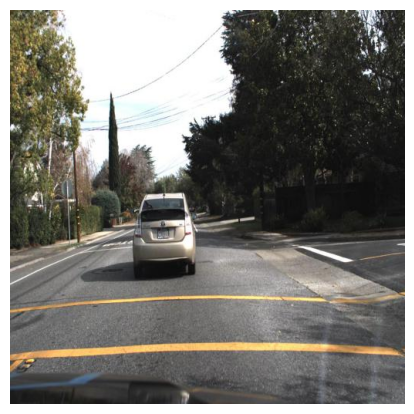

In [77]:
car_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None, file_pct=0.5)

car_data.show_with_box(index=53, color='r', label=False, lw=0)

In [66]:
car_data[53][0]

tensor([[[103, 101, 100,  ...,  41,  96,  41],
         [ 91,  90,  89,  ...,  34,  64,  29],
         [ 76,  80,  79,  ...,  43,  50,  38],
         ...,
         [ 26,  26,  26,  ..., 110, 106, 100],
         [ 26,  26,  26,  ..., 113, 106,  96],
         [ 26,  26,  26,  ..., 120, 109,  94]],

        [[ 88,  86,  86,  ...,  42,  97,  42],
         [ 76,  76,  75,  ...,  35,  65,  30],
         [ 62,  66,  68,  ...,  44,  51,  39],
         ...,
         [ 26,  26,  26,  ..., 111, 107, 101],
         [ 26,  26,  26,  ..., 114, 107,  97],
         [ 26,  26,  26,  ..., 121, 110,  95]],

        [[ 59,  57,  57,  ...,  36,  92,  37],
         [ 47,  47,  46,  ...,  29,  60,  25],
         [ 35,  39,  40,  ...,  38,  46,  34],
         ...,
         [ 26,  26,  26,  ..., 113, 109, 103],
         [ 26,  26,  26,  ..., 116, 109,  99],
         [ 26,  26,  26,  ..., 123, 112,  97]]], dtype=torch.uint8)

In [129]:
testmodel = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, bias=False, padding=2)

# with torch.no_grad():
#     for i in range(0,3):
#         for j in range(0,3):
#             testmodel.weight[i, j] = (1 / (3 * 5)) * torch.eye(5)

testmodel.weight.data

tensor([[[[-0.1048, -0.0725, -0.0519,  0.1045,  0.0931],
          [-0.1154,  0.1032,  0.0613,  0.0828,  0.0675],
          [ 0.0343, -0.0729,  0.0300,  0.0115, -0.0006],
          [-0.0661,  0.0986, -0.1127, -0.0633, -0.0045],
          [-0.0577,  0.0222, -0.0469, -0.0268,  0.0566]],

         [[-0.0137,  0.0831,  0.1088, -0.0671, -0.0954],
          [ 0.0237, -0.0401,  0.0989, -0.1106,  0.0684],
          [ 0.1003, -0.0690, -0.0707, -0.0084,  0.1081],
          [-0.1006, -0.0966,  0.1066, -0.0685, -0.0574],
          [-0.0433,  0.0379, -0.0326,  0.0105,  0.0995]],

         [[ 0.1072, -0.0161,  0.0851, -0.0577,  0.0446],
          [ 0.0056,  0.0025,  0.1073,  0.0186,  0.0644],
          [ 0.1147, -0.0543, -0.0693, -0.0544, -0.0618],
          [ 0.0007, -0.0309, -0.0891, -0.0184, -0.0648],
          [ 0.0161,  0.0918,  0.0690, -0.0676,  0.0965]]],


        [[[ 0.0946, -0.1108, -0.0384, -0.0087, -0.1113],
          [ 0.0788, -0.0138, -0.0051, -0.0892, -0.0841],
          [ 0.0222, -0.

In [74]:
def show_tensor_image(img):
        
        # convert the image to a numpy array

        if isinstance(img, Image.Image):
            arr = np.array(img)
        elif isinstance(img, np.ndarray):
            arr = img
            if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
                arr = np.transpose(arr, (1, 2, 0))
        elif isinstance(img, torch.Tensor):
            t = img.detach().cpu()
            if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
                t = t.permute(1, 2, 0)
            arr = t.numpy()
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        if arr.dtype.kind == "f" and arr.max() <= 1.0:
            arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        

        # plot image
        H, W = arr.shape[:2]
        dpi = 100
        fig, ax = plt.subplots(figsize=(W/dpi, H/dpi), dpi=dpi)
        ax.imshow(arr)  # origin='upper' -> y downward, matches image coords
        
        ax.axis("off")

        plt.close(fig)
        return fig

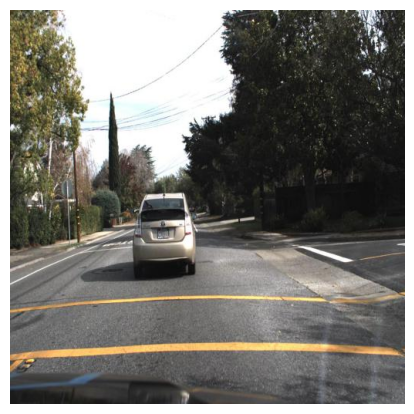

In [75]:
show_tensor_image(car_data[53][0])

In [130]:
sample_img = car_data[53][0].float()

sample_img_Conv = testmodel(sample_img.unsqueeze(dim=0))

In [131]:
sample_img_Conv.max()

tensor(133.5010, grad_fn=<MaxBackward1>)

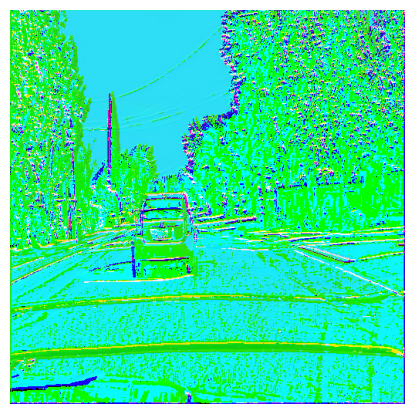

In [132]:
show_tensor_image(sample_img_Conv.squeeze())

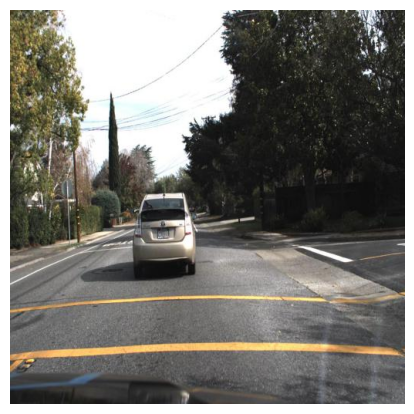

In [121]:
show_tensor_image(sample_img)